# The Challenge with Generating Coherent Text

- For task specific heads like sequence or token classification,generating predictions is farily stragihtforwad

    - Model produces somelogits and wiehter take the maixum value tog et the predicted class or apply a softmax function to obtain the predicted probabilities per class.


- By contrast, converting the models probabilistic output to text requires a decoding method, which introduces a few challenges that are unique to text generation:
    - The decoding is done iteratively and thus involves significantly more compute than simply passing inputs once through the forward pass of a model

    - The quality and diversity of the generated text depend on the choice of decoding method and associated hyperparameters

- Like other *autoregressive or casual language* model, GPT-2 is pretrained to estimate the probability P(y|x) of a sequence of tokens **y=y1,y2,....,yt** occuring in the text, given some initial prompt or context sequence **x=x1,x2,....,xt**

- Since it is impractical to acquire enough training data to estimate P(y|x) directly, it is common to use the chain rule of probability to factoriaze it as a product of conditional probabilities.


`P(y1,....yt|x)= ΠⁿₜP(yₜ|y<ₜ,x)`


- Where y< is a shorthand notation for the sequence y1,...yₜ-1. It is from these coniditonla probabilities that we pick up the intuition that autoregressive language modeling amounts to predicting each word given the preceding words in a sentence; this is exactly what the probability on the righthand side of the preceding equation describes.

- This pretraining objectiev is quite different from BERT's which utilizes both past and future context to predict a masked token


- But we can adapt this next token prediction task to generate text sequences of arbitrary length.


We start with a prompt like 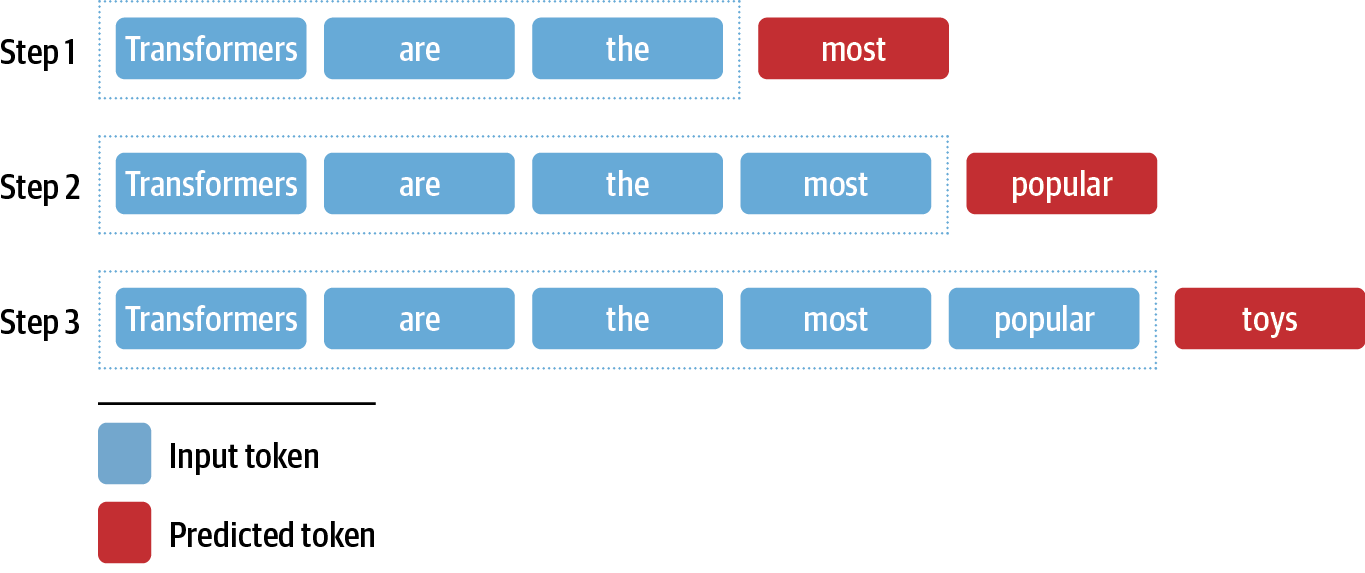

Since the output sequence is conditioned on the choice of input prompt, this type of text generation is often called conditional text generation


- At the heart of this process lies a decoding method that determines which token is selected at each timestep. Since the language model head produces a logit zₜ,ᵢ per token  in the vocabulary at each step, we can get the probability distribution over the next possible token wᵢ by taking the softmax

P(yₜ=wᵢ|y<ₜ,x)=softmax(zₜ,ᵢ)

The goal of most decoding method is to search for the most likely overall sequence by picking y^ such that:

y^=argmaxP(y|x)


- Finding y^ directly would involve evaulating every possible sequence with the language model.

    - Since there is no algorithm that can do this in a reasonable amount of time, we rely on **approximations** instead.


## Greedy Search Decoding

- The simplest decoding method to get discrete tokens from a model's continous outputis to greedily select the token with the highest probability at each timestep

y^=argmaxP(yₜ|y<ₜ,x)


In [1]:
!pip install accelerate transformers datasets torch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00


In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device="cuda" if torch.cuda.is_available() else 'cpu'
model_name='gpt2-xl'
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForCausalLM.from_pretrained(model_name).to(device)

To warm up, we'll take the same iterative approach shown in the figure: We will use "Transformers are the" as teh input prompt and run the decoding for eight timesteps.
- At each timestep, we pick out the model's logits for the las token in the prompt and wrap them with a softmax to get a probability distribution.

- We thne pick the next token with the highest probability, add it to the input sequence and run the process again.

In [30]:
import pandas as pd

input_txt="Transformer are the"
input_ids=tokenizer(input_txt,return_tensors='pt')['input_ids'].to(device)
iterations=[]
n_steps=8
choices_per_step=5

with torch.no_grad():
    for _ in range(n_steps):
        iteration=dict()
        print(f"Input_ids:{input_ids[0]}")
        iteration["Input"]=tokenizer.decode(input_ids[0])
        print(f"Tokenized Input:{iteration['Input']}")
        output=model(input_ids=input_ids)

        #Select logits of the first batch and the last token and apply softmax

        next_token_logits=output.logits[0,-1,:]
        print(f"Next Token Logits: {next_token_logits}")
        next_token_probs=torch.softmax(next_token_logits,dim=-1)
        print(f"Next Token Probabilities: {next_token_probs}")
        sorted_ids=torch.argsort(next_token_probs,dim=-1,descending=True)
        print(f"Sorted Token IDS: {sorted_ids}")

        #Store tokens with highest probabilities

        for choice_idx in range(choices_per_step):
            token_id=sorted_ids[choice_idx]
            print(f"Choice ID:{choice_idx+1} \n Token ID: {token_id}")
            token_prob=next_token_probs[token_id].cpu().numpy()
            print(f"Token Probability for the given id: {token_prob}")
            token_choice=(
                f"{tokenizer.decode(token_id)} ({100*token_prob:.2f}%)"
            )
            print(f"For Choice {choice_idx+1}\n\n TOKEN CHOICE:{token_choice} ")

            iteration[f'Choice {choice_idx+1}']=token_choice

        #Append predicted next token to input
        input_ids=torch.cat([input_ids,sorted_ids[None,0,None]],dim=-1)
        print(f'Input ids:{input_ids}')
        print(f"Iteration:{iteration}")
        iterations.append(iteration)


pd.DataFrame(iterations)




Input_ids:tensor([ 8291, 16354,   389,   262])
Tokenized Input:Transformer are the
Next Token Logits: tensor([-0.2843, -0.2621, -3.6675,  ..., -2.8004, -5.4686, -0.3450])
Next Token Probabilities: tensor([1.0233e-05, 1.0463e-05, 3.4731e-07,  ..., 8.2656e-07, 5.7347e-08,
        9.6308e-06])
Sorted Token IDS: tensor([749, 691, 976,  ..., 216, 181, 189])
Choice ID:1 
 Token ID: 749
Token Probability for the given id: 0.09198151528835297
For Choice 1

 TOKEN CHOICE: most (9.20%) 
Choice ID:2 
 Token ID: 691
Token Probability for the given id: 0.0413125716149807
For Choice 2

 TOKEN CHOICE: only (4.13%) 
Choice ID:3 
 Token ID: 976
Token Probability for the given id: 0.04066486656665802
For Choice 3

 TOKEN CHOICE: same (4.07%) 
Choice ID:4 
 Token ID: 4755
Token Probability for the given id: 0.03300926834344864
For Choice 4

 TOKEN CHOICE: core (3.30%) 
Choice ID:5 
 Token ID: 3392
Token Probability for the given id: 0.02973749302327633
For Choice 5

 TOKEN CHOICE: ones (2.97%) 
Input ids

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformer are the,most (9.20%),only (4.13%),same (4.07%),core (3.30%),ones (2.97%)
1,Transformer are the most,common (19.33%),important (11.11%),popular (5.48%),powerful (5.08%),commonly (4.10%)
2,Transformer are the most common,types (7.73%),type (5.39%),. (4.97%),", (4.80%)",and (4.66%)
3,Transformer are the most common types,of (76.20%),. (5.01%),used (3.97%),", (3.34%)",in (1.40%)
4,Transformer are the most common types of,mod (5.03%),mods (4.12%),transformer (3.07%),trans (2.15%),Transformers (1.59%)
5,Transformer are the most common types of mod,. (13.87%),ded (11.06%),", (7.68%)",in (6.82%),ulators (6.42%)
6,Transformer are the most common types of mod.,They (21.68%),\n (12.27%),The (5.73%),There (3.06%),Most (2.65%)
7,Transformer are the most common types of mod. ...,are (30.61%),can (6.57%),'re (5.00%),add (3.25%),have (3.23%)


- We can see that multiple possible continuations at each step, which shows the iterative nature of text generation. Unlike other tasks such as sequence classification where a single forward pass suffices to generate the predictions,

 - with text generation we need to decode the output tokens one at a time

Implementing Greedy Search wasn't too hard, but we'll want to use the built-in generate function from transformers to esxplore more sophisticated decoding methods.

In [31]:
input_ids=tokenizer(input_txt,return_tensors='pt')['input_ids'].to(device)
# ValueError: The following `model_kwargs` are not used by the model: ['do_samples'] (note: typos in the generate arguments will also show up in this list)
output=model.generate(input_ids,max_new_tokens=n_steps)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformer are the most common types of mod. They are


In [40]:
max_length=128
input_txt="""In a shocking finding, scientist discovered\
a herd of unicorns living in a remote, previously unexplored\
valley, in the Andes Mountains. Even more suprising to the \
researches was the fact that the unicorns spoke perfect English \n\n
"""

input_ids=tokenizer(input_txt,return_tensors='pt')['input_ids'].to(device)
output_greedy=model.generate(input_ids,max_length=max_length)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The researchers, from the University of California, Davis, were conducting a study on the Andean unicorn, a species of animal that is native to the Andes Mountains. The researchers were searching for the unicorn's natural habitat, and were surprised to find a herd of the animals living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the


- One of the main drawbacks with greedy search decoding: it tends to produce repetitive output sequences, which is certainly undesirable in a news article.

- This is a common problem with  greedy search algorithms, which can fail to give you the optimal solution:
    - In the context of decoding, they can miss word sequences whose overall probability is higher just because high probability words happen to be preceded by low-probability ones

- Although greedy search decoding is rarely used for text generation tasks that require diversity, it can be useful for producing short sequences like arithmetic where a deterministic and factually correct output is preferred
    - For these tasks, we can condition GPT-2 by providing a fe line- sparated examples in the format" 5+8=>13\n 7+2 =>0 \n 1+0 =>" as the input prompt


Fortunately we can do better : **Beam Search Decoding**


## Beam Search Decoding

- Instead of decoding the token with the highest probability at each step, beam search keeps track of the top b most probable next tokens, where b is referred to as the number of beams or partial hypotheses.


- The next set of beams are chosen by considering all possible next-token extensions of the existing set and selecting the b most likely extensions

- The process is repeated until we reach the maximum length or an EOS token

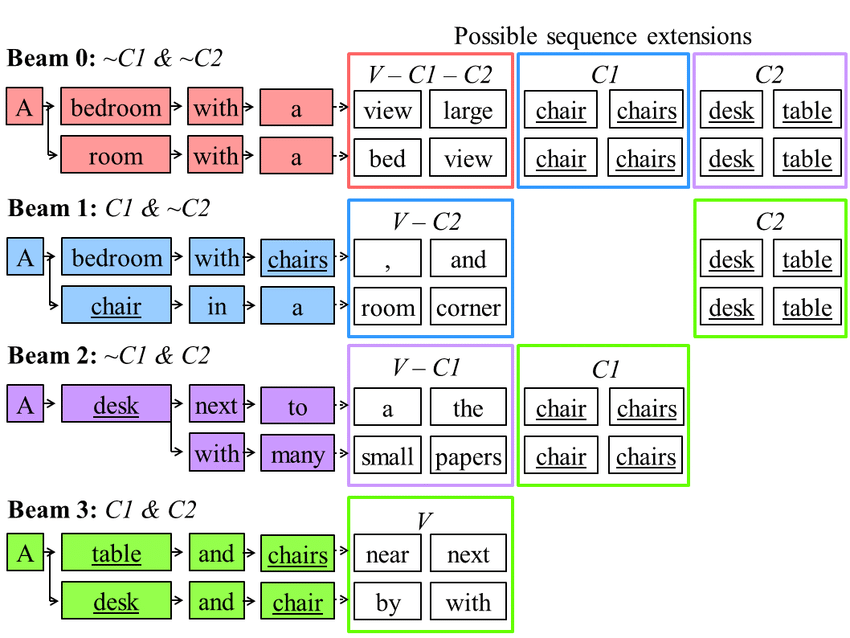


## Why do we score the sequences using log probabilities instead of the probabilities themselves?

- Calculating the overall probability of a sequence P(y1,y2,....,yt|X) involves calcualting a product of conditional probabilities P(yₜ|y<ₜ,x) is one reason
    - Since each conditional probability is typically a small number in the range [0,1], taking their product can lead to an overall probability thatcan easily underflow.

    - This means that the computer can no longer precisely represent the result of the calculation

- For example, suppose we have a sequence of t=1024 tokens and generaously assum that the probability for each token is 0.5. The overall probability for this sequence is an extremely small number:

In [28]:
0.5**1024

5.562684646268003e-309

Which leads to numerical instability as we run into underflow.

- We can avoid this by calculating a related term, the log probability. If we apply the lograithm to the joint and conditional probabilities, then with the help of the product rule for logarithms  we get:

logP(y1,...yt|x)=ΣlogP(yₜ|y<ₜ,x)



product of probabilities becomes a sum of log probabilities, which is much less likely to run into numerical instabilities.

In [32]:
import numpy as np

sum([np.log(0.5)]*1024)

-709.7827128933695

- Transformers models return the unnormalized logits for the next token given the input tokens, we first need to normalize the logits to creaate a probability distribution over the whole vocabulary for each token in the sequence.


- We then need to select only the token probabilities that were present in the sequence.

In [11]:
import torch.nn.functional as F

def log_probs_from_logits(logits,labels):
    logp=F.log_softmax(logits,dim=-1)
    logp_label=torch.gather(logp,2,labels.unsqueeze(2)).squeeze(-1)
    return logp_label

This gives us the log probability for a single token, so to get the toal log probability of a sequence we just need to sum the log probabilities for each token:

In [33]:
def sequence_logprob(model,labels,input_len=0):
    with torch.no_grad():
        output=model(labels)
        log_probs=log_probs_from_logits(
            output.logits[:,:-1,:],labels[:,1:]
        )
        seq_log_prob=torch.sum(log_probs[:,input_len:])

        return seq_log_prob.cpu().numpy()

- Note thta we ignore the input proabilities of the input sequence because they are not generated by the model.

In [36]:
logp=sequence_logprob(model,output_greedy,input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The researchers, from the University of California, Davis, were conducting a study on the Andean unicorn, a species of animal that is native to the Andes Mountains. The researchers were searching for the unicorn's natural habitat, and were surprised to find a herd of the animals living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the

log-prob: -235.27


In [41]:
# RESULTS WITH BEAM SEARCH

output_beam=model.generate(input_ids,max_length=max_length,num_beams=5)

logp=sequence_logprob(model,output_beam,input_len=len(input_ids[0]))

print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English

The discovery was made by a team of scientists from the Universidad Nacional Autónoma de México (UNAM) and the

log-prob: -23.14


- We can see that we geta better log probability (higher is better) with beam search than we did with simple greedy decoding

- However we can seee that beam search also suffers from repetitive text.

- One way to address this is to impose an n-gram penalyty with the no_repeat_ngram_size parameter that racks which n-grams have been seen and sets the next token probability to zero if it would produce a previously seen n-gram:


In [42]:
output_beam=model.generate(input_ids,max_length=max_length,num_beams=5,no_repeat_ngram_size=2)

log=sequence_logprob(model,output_beam,input_len=len(input_ids[0]))

print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society. They were conducting a survey of the area when they came across the herd, which had been living there for more than a century.

"We were surprised to find such a large group of animals in such an isolated location," said Dr. David Shiffman,

log-prob: -23.14


- Despite scoring a lower probabilt, th text reamins coherent.

# Sampling Methods

- Simplest sampling methods is to randomly sample from the probability distribution of the model's outputs over the full vocabulary at each timestep:


P(yₜ=wᵢ|y<ₜ,x)=softmax(zₜ,ᵢ)=exp(zₜ,ᵢ)/ (Σⱽⱼ=1 exp(zₜᵢ))

Where |V| denotest the cardinality of the vocabulary.

- We can easily control the diversity of the output by adding a temperature parameter T that rescales the logits before taking the softmax


- P(yₜ=wᵢ|y<ₜ,x)=exp(zₜ,ᵢ/T)/ (Σⱽⱼ=1 exp(zₜᵢ/T))

By tuning T we can control the shape of the probability distribution:
-  When T<1, the distibution becomes peaked around the orign and the rare tokens are surpressed

- When T>1, the distribution flattens out and each toke. becomes equally likely

In [43]:
output_temp=model.generate(input_ids,max_length=max_length,temperature=2,top_k=0)

print(tokenizer.decode(output_temp[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The researchers, from the University of California, Davis, were conducting a study on the Andean unicorn, a species of animal that is native to the Andes Mountains. The researchers were searching for the unicorn's natural habitat, and were surprised to find a herd of the animals living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the


### We can see that high temperatur has produced mostly gibberish; by accentuating the rare tokens,

In [44]:
output_temp=model.generate(input_ids,max_length=max_length,temperature=0.5,top_k=0)

print(tokenizer.decode(output_temp[0]))


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The researchers, from the University of California, Davis, were conducting a study on the Andean unicorn, a species of animal that is native to the Andes Mountains. The researchers were searching for the unicorn's natural habitat, and were surprised to find a herd of the animals living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the


### Temperature allows us to control the quality of sample bu there is always a trade-off between coherence( lower temperature) and diversity(high temperature) that has to tune the use case at hand.

- Another Way to adjust the trade-off between coherence and diversity is to truncate the distribution of the vocabulary.

- This allows us to adjut the diversity frely with the temperature, but in a more limited range that exlcudes wordds that would be too strange in the context (low probability words). There are two main ways to do this:


1. **Top-k**
2. **Nucleus Sampling**


## Top-k
- The idea behind this sampling methods is to avoid the low probability choices by only sampling the k tokens with the highest probability. This puts a fixed cut on the long tail of the distribution and ensure that we only sample from likly choices

In [45]:
output_topk=model.generate(input_ids,max_length=250,top_k=50)

print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The researchers, from the University of California, Davis, were conducting a study on the Andean unicorn, a species of animal that is native to the Andes Mountains. The researchers were searching for the unicorn's natural habitat, and were surprised to find a herd of the animals living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English, and were able to communicate with humans.


The researchers believe that the unicorns are the descendants of the ancient Incas, who were known to have had a close relationship with the unicorns. The researchers believe that the unicorns are the descendants of the ancient Incas, who were known to have had a close relationship

#### How do we choose k?
- k value is chosen manually and is the same for each choice in the sequence, independent of the actual output distribution.


## Top-p
- An alternative is to use a dynamic cutoff. With nucleus-p sampling, instead of choosing a fixed cutoff value, we set a condition of when to cut off.

This condition is when a certain probability mass in the selection is reached.

- Lets say we set that value to .95
 - We then order all tokens in descending order by probability and ad one token after anotehr from the top of the list until the sum of the probabilities of the selected tokens is .95

 - The value for p defines a horizontal line on the cumulative sum of probabilities plot, and we sample only from tokens below the line.

 - Depending on the output distribution this could be just one (very likely) token or a hundre( more equally likely) tokens

In [46]:
output_topp=model.generate(input_ids,max_length=max_length,top_p=.9)
print(tokenizer.decode(output_topp[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovereda herd of unicorns living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the researches was the fact that the unicorns spoke perfect English 


The researchers, from the University of California, Davis, were conducting a study on the Andean unicorn, a species of animal that is native to the Andes Mountains. The researchers were searching for the unicorn's natural habitat, and were surprised to find a herd of the animals living in a remote, previously unexploredvalley, in the Andes Mountains. Even more suprising to the


#### You can combine both sampling approaches to get the bes of both worlds.
- Setting top_k=50 and top_p=.9 corresponds to the rule of choosing tokens with a probability mass of .9 from a pool of at most 50 tokens